## Loading File and Extracting Data set

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

# Load the dataset
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},   # Combine Date & Time into one column
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)

# Convert numeric columns
num_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Handle missing values (option: drop or fill)
df.dropna(inplace=True)

# Create new time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday  # 0 = Monday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Create new energy-based features
# Sub_metering is in watt-hour; convert global_active_power to watt-minute for comparison
df['global_active_energy_wh'] = df['Global_active_power'] * 1000 / 60  # convert kW to Wh per minute
df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['non_measured_power'] = df['global_active_energy_wh'] - df['total_sub_metering']

# Preview the processed data
print(df.head())

# Save the processed DataFrame to CSV
df.to_csv('processed_energy_data.csv')

print("Processed data saved to 'processed_energy_data.csv'")


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

## Doing EDA

In [18]:
# Step 1: Shape and column info
print("Shape of data:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

# Step 2: Info about datatypes and nulls
print("\nData Types and Nulls:\n")
print(df.info())

# Step 3: Descriptive statistics
print("\nDescriptive Stats for Numeric Features:\n")
print(df.describe())


Shape of data: (2049280, 15)

Column Names:
 ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day', 'month', 'weekday', 'is_weekend', 'global_active_energy_wh', 'total_sub_metering', 'non_measured_power']

Data Types and Nulls:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Global_active_power      float64
 1   Global_reactive_power    float64
 2   Voltage                  float64
 3   Global_intensity         float64
 4   Sub_metering_1           float64
 5   Sub_metering_2           float64
 6   Sub_metering_3           float64
 7   hour                     int32  
 8   day                      int32  
 9   month                    int32  
 10  weekday                  int32  
 11  is_weekend               int64  

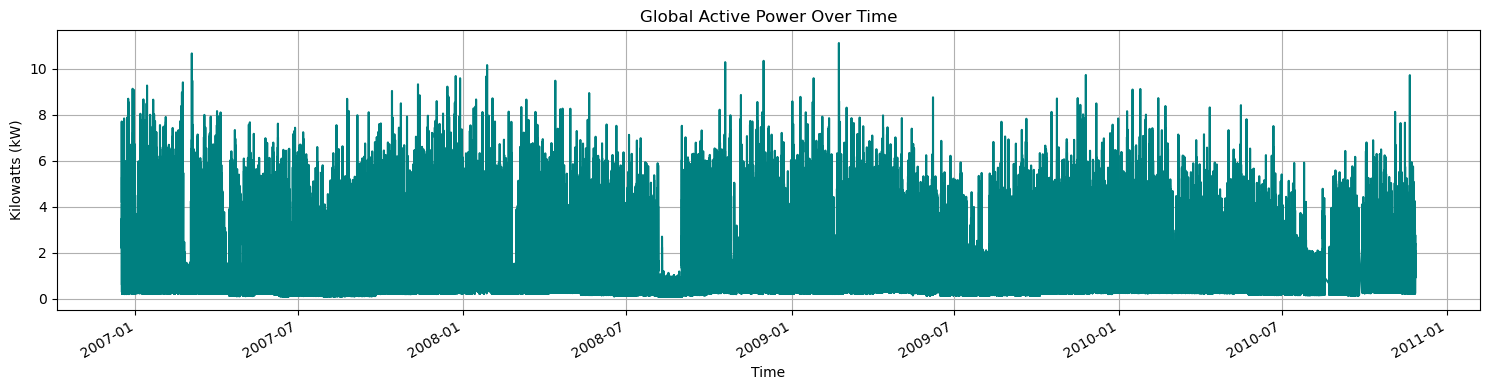

In [19]:
# Plot Global Active Power Over Time
df['Global_active_power'].plot(figsize=(15, 4), title="Global Active Power Over Time", color='teal')
plt.ylabel("Kilowatts (kW)")
plt.xlabel("Time")
plt.grid()
plt.tight_layout()
plt.show()


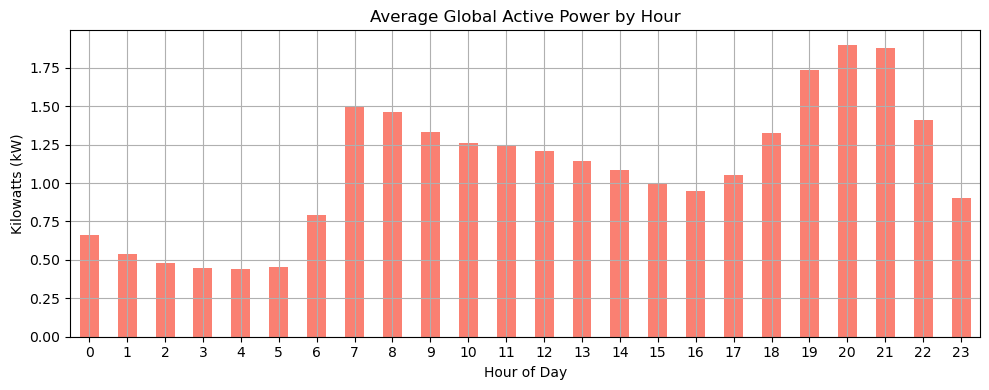

In [20]:
# Mean Global Active Power for each hour of the day
df.groupby('hour')['Global_active_power'].mean().plot(
    kind='bar', figsize=(10, 4), color='salmon'
)
plt.title('Average Global Active Power by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Kilowatts (kW)')
plt.grid()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


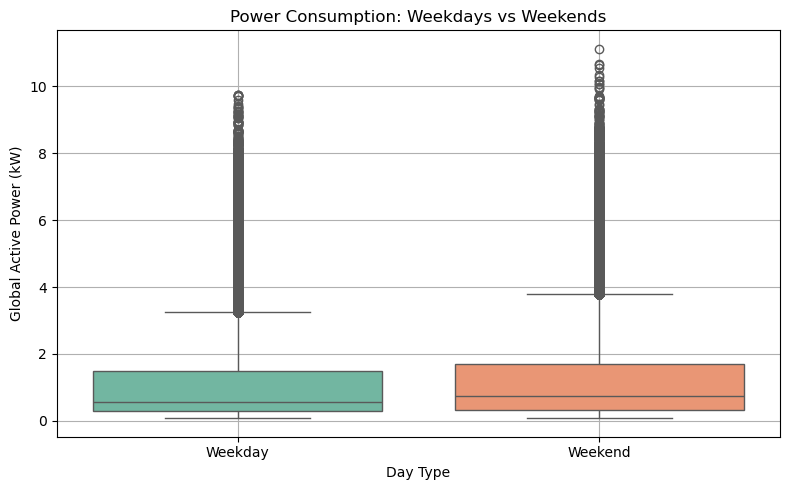

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Weekday vs Weekend Power Consumption Comparison
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_weekend', y='Global_active_power', data=df, palette='Set2')
plt.title("Power Consumption: Weekdays vs Weekends")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.ylabel("Global Active Power (kW)")
plt.xlabel("Day Type")
plt.grid()
plt.tight_layout()
plt.show()


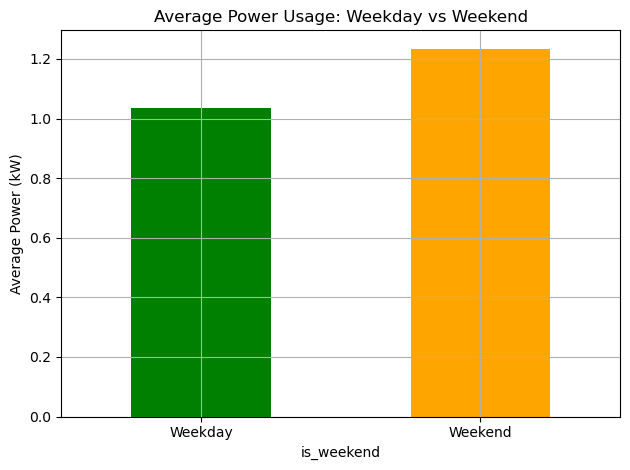

In [22]:
# Bar plot for average Global Active Power by day type
df.groupby('is_weekend')['Global_active_power'].mean().plot(kind='bar', color=['green', 'orange'])
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel("Average Power (kW)")
plt.title("Average Power Usage: Weekday vs Weekend")
plt.grid()
plt.tight_layout()
plt.show()


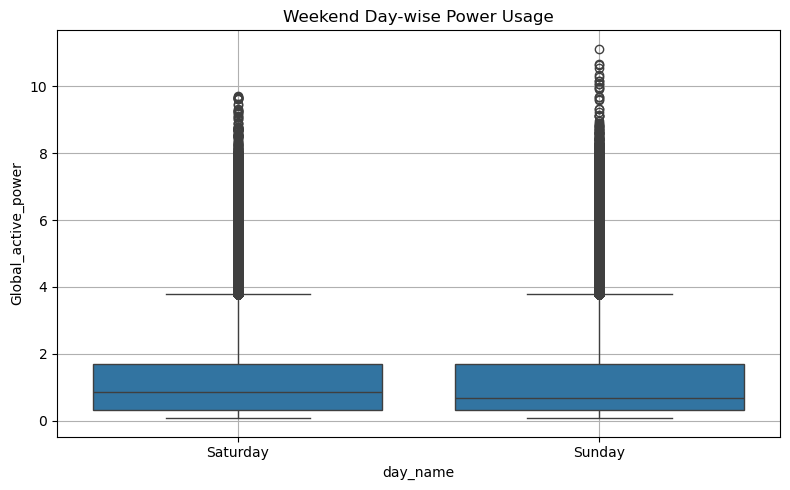

In [23]:
# Add actual day name
df['day_name'] = df.index.day_name()

# Compare Saturday vs Sunday
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.boxplot(x='day_name', y='Global_active_power', data=df[df['is_weekend'] == 1])
plt.title("Weekend Day-wise Power Usage")
plt.grid()
plt.tight_layout()
plt.show()


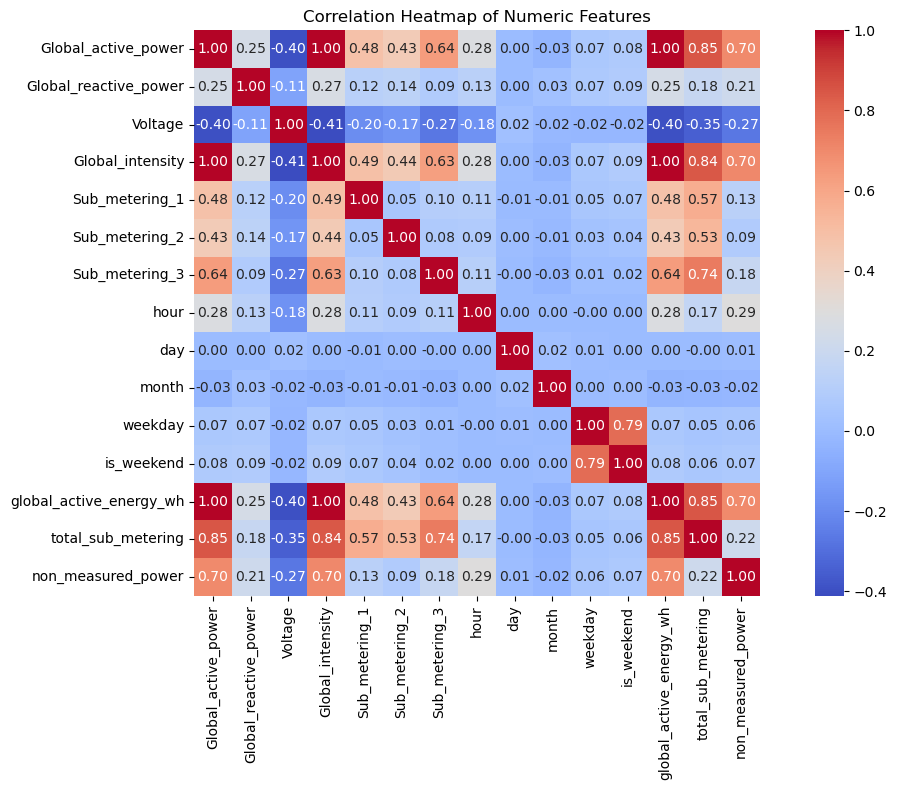

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Generate correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


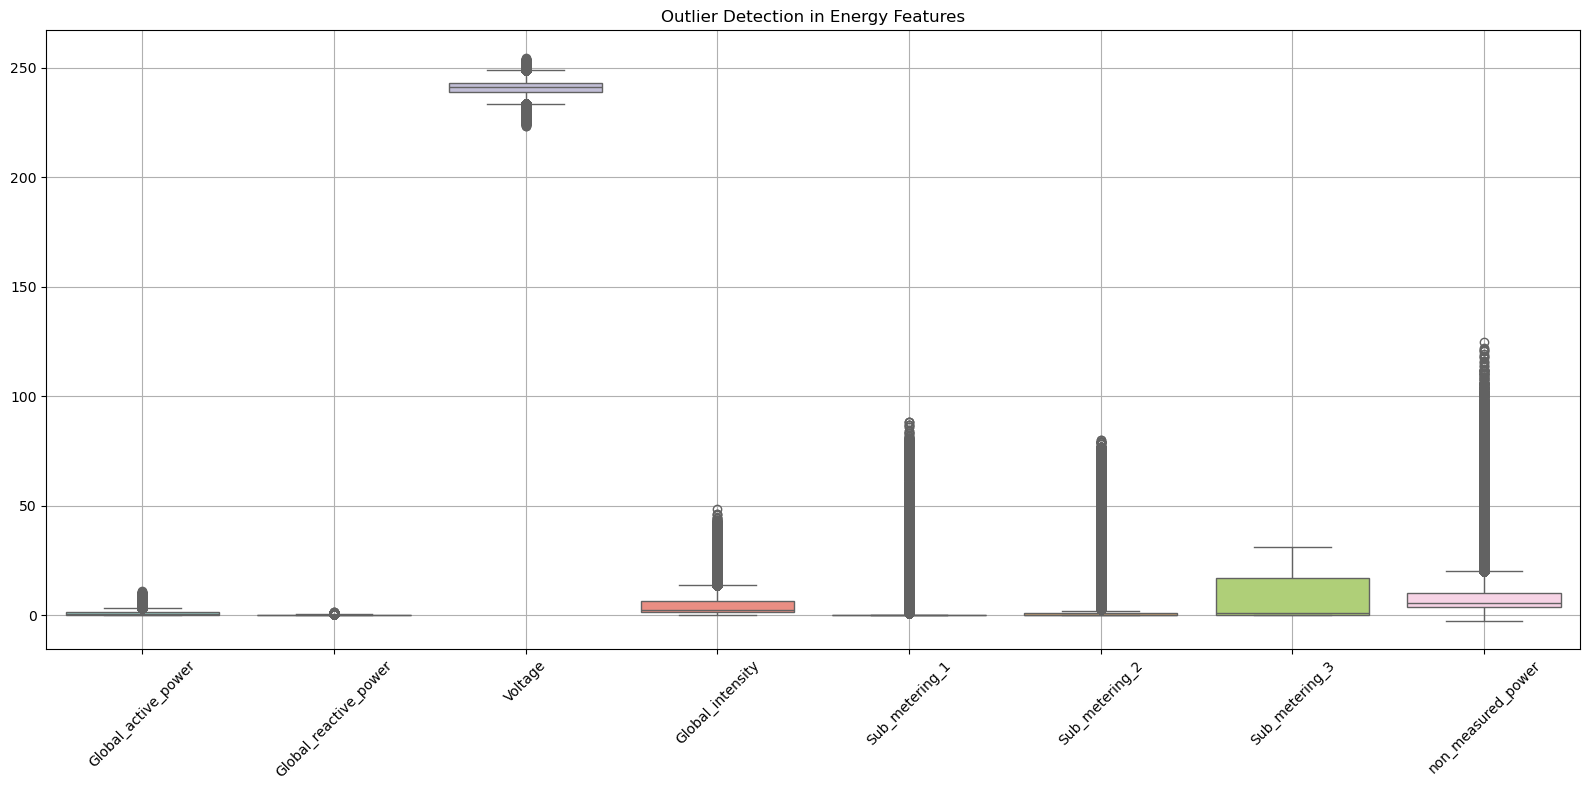

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to check for outliers
features_to_plot = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'non_measured_power'
]

# Plot
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[features_to_plot], palette='Set3')
plt.xticks(rotation=45)
plt.title("Outlier Detection in Energy Features")
plt.grid()
plt.tight_layout()
plt.show()


## Model Building Phase

In [27]:
# Feature Selection + Train-Test Split
from sklearn.model_selection import train_test_split

# Features we'll use to predict Global_active_power
features = [
    'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'weekday', 'is_weekend'
]

# X = input features, y = target
X = df[features]
y = df['Global_active_power']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show confirmation
print("Data split complete")
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Data split complete
Training set size: (1639424, 9)
Test set size: (409856, 9)


## Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results")
print("RMSE:", round(lr_rmse, 4))
print("MAE:", round(lr_mae, 4))
print("R² Score:", round(lr_r2, 4))


Linear Regression Results
RMSE: 0.0403
MAE: 0.0258
R² Score: 0.9986


## Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Print results
print("Random Forest Results")
print("RMSE:", round(rf_rmse, 4))
print("MAE:", round(rf_mae, 4))
print("R² Score:", round(rf_r2, 4))


Random Forest Results
RMSE: 0.028
MAE: 0.015
R² Score: 0.9993


## Reporting & Insights

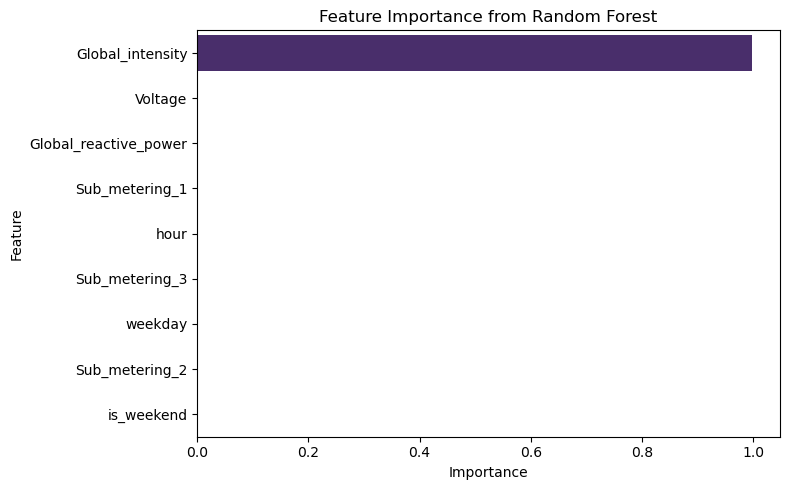

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()




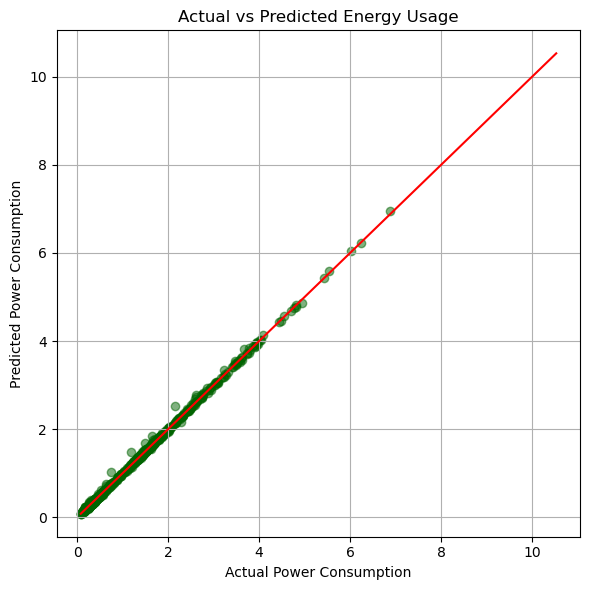

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:1000], y_pred_rf[:1000], alpha=0.5, color='darkgreen')
plt.xlabel("Actual Power Consumption")
plt.ylabel("Predicted Power Consumption")
plt.title("Actual vs Predicted Energy Usage")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # diagonal line
plt.tight_layout()
plt.grid(True)
plt.show()


## Export into MySQL

In [36]:
pip install mysql-connector-python sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import mysql.connector
from mysql.connector import errorcode

# Load the CSV and clean
df = pd.read_csv("processed_energy_data.csv")
df = df.dropna()

# Convert correct datatypes (excluding Datetime and day_name)
df = df.astype({
    'Global_active_power': 'float',
    'Global_reactive_power': 'float',
    'Voltage': 'float',
    'Global_intensity': 'float',
    'Sub_metering_1': 'float',
    'Sub_metering_2': 'float',
    'Sub_metering_3': 'float',
    'hour': 'int',
    'day': 'int',
    'month': 'int',
    'weekday': 'int',
    'is_weekend': 'int',
    'global_active_energy_wh': 'float',
    'total_sub_metering': 'float',
    'non_measured_power': 'float'
})

# Connect to MySQL and create DB if needed
try:
    root_conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Dark2020@"
    )
    root_cursor = root_conn.cursor()
    root_cursor.execute("CREATE DATABASE IF NOT EXISTS PowerPulse")
    root_cursor.close()
    root_conn.close()
    print("Database 'PowerPulse' created or already exists.")
except mysql.connector.Error as err:
    print("Database creation error:", err)

# Connect to PowerPulse DB
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Dark2020@",
    database="PowerPulse"
)
cursor = conn.cursor()

# Create table if not exists
cursor.execute("""
CREATE TABLE IF NOT EXISTS energy_data (
    Global_active_power FLOAT,
    Global_reactive_power FLOAT,
    Voltage FLOAT,
    Global_intensity FLOAT,
    Sub_metering_1 FLOAT,
    Sub_metering_2 FLOAT,
    Sub_metering_3 FLOAT,
    hour INT,
    day INT,
    month INT,
    weekday INT,
    is_weekend TINYINT,
    global_active_energy_wh FLOAT,
    total_sub_metering FLOAT,
    non_measured_power FLOAT
)
""")
conn.commit()
print("Table 'energy_data' ready.")

# Prepare data (only required 15 columns)
data = df[[
    'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'day', 'month', 'weekday', 'is_weekend',
    'global_active_energy_wh', 'total_sub_metering', 'non_measured_power'
]].values.tolist()

# Insert all rows in batches
insert_query = """
INSERT INTO energy_data (
    Global_active_power, Global_reactive_power, Voltage, Global_intensity,
    Sub_metering_1, Sub_metering_2, Sub_metering_3,
    hour, day, month, weekday, is_weekend,
    global_active_energy_wh, total_sub_metering, non_measured_power
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

batch_size = 10000
for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data[start:end]
    cursor.executemany(insert_query, batch)
    conn.commit()
    

# Cleanup
cursor.close()
conn.close()
print("All data inserted into 'PowerPulse.energy_data' successfully!")


Database 'PowerPulse' created or already exists.
Table 'energy_data' ready.
All data inserted into 'PowerPulse.energy_data' successfully!


In [53]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [56]:
import joblib

# Assuming your trained model is called 'rf_model'
joblib.dump(rf_model, "powerpulse_model.pkl")

print("Model exported successfully!")


Model exported successfully!
